# MNIST dataset processed with a Visual Transformer

This notebook shows how to use the ViT model to train the MNIST dataset. NOTE: **The ViT model is not recommended for small datasets, like the MNIST one**

## Preparatives

The following sentence is needed to be able to import the `MNIST` model from this notebook

In [15]:
import sys
sys.path.append('../')  # to be able to import the MNIST model

Let's load the MNIST dataset. We would need to install the `torchvision` package (e.g, `pip install torchvision`), additionally to the `torch` package

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Reset the random seed to get deterministic results 

In [18]:
torch.manual_seed(0)

## Hyper parameters

In [19]:
BATCH_SIZE = 64
LR = 5e-5
EPOCHS = 10

## Preprocessing

In [20]:
mean, std = (0.5,), (0.5,)

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

In [21]:
train_data = datasets.MNIST('../data/', download=True, train=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = datasets.MNIST('../data/', download=True, train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
def draw(dataset, idx: int) -> None:
    plt.title(f'label: {dataset.targets[idx].item()}')
    plt.imshow(dataset.data[idx].int())

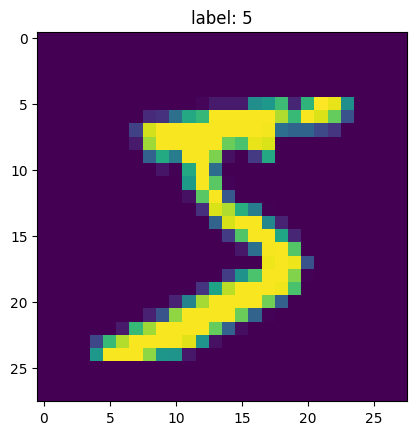

In [23]:
draw(train_data, 0)

## Model

In [24]:
from models import MNISTViTModel

In [25]:
model = MNISTViTModel().to(device)
model

MNISTViTModel(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=7, p2=7)
    (1): Linear(in_features=49, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.2, inplace=False)
            (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=256, bias=True)
              (1): Dropout(p=0.2, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=256, out_features

In [26]:
for batch, labels in train_dataloader:
    batch = batch.to(device)
    labels = labels.to(device)
    
    print(f'Batch Image Dimensions: {batch.size()}')
    print(f'Labels Dimensions: {labels.size()}')
    print('-'*100)
    
    out = model(batch)
    
    print(f'Output Dimensions: {out.size()}')
    print(f'Out: {out[0]}')
    break

Batch Image Dimensions: torch.Size([64, 1, 28, 28])
Labels Dimensions: torch.Size([64])
----------------------------------------------------------------------------------------------------
Output Dimensions: torch.Size([64, 10])
Out: tensor([ 1.2751, -0.1681,  0.2710,  0.0562, -0.7360,  0.1433, -1.4317,  0.0658,
         0.0299,  0.0276], device='cuda:0', grad_fn=<SelectBackward0>)


In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

## Training

In [28]:
train_size = len(train_dataloader.dataset)
test_size = len(train_dataloader.dataset)

hist_track = {
    'accuracy': [],
    'loss': [],
}

for t in range(EPOCHS):
    print(f'Epoch {t+1}\n-------------------------------')
    model.train()
            
    for batch, (loss, X, y, pred) in enumerate(model.train_gen(train_dataloader, loss_fn, optimizer)):
        if batch % 100 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE
            print(f'loss: {loss:>7f}  [{current:>5d}/{train_size:>5d}]')
    test_loss, accuracy = model.test_gen(test_dataloader, loss_fn)
    hist_track['loss'].append(test_loss)
    hist_track['accuracy'].append(100 * accuracy)
    print(f'Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n')
print('Done!')

NameError: name 't' is not defined

## Evaluating the trained model

In [ ]:
plt.plot(hist_track['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(hist_track['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
def eval_image(model: nn.Module, X: torch.Tensor):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        pred = model(X)
        return pred[0].argmax(0).item()


In [ ]:
test_features, test_labels = next(iter(test_dataloader))

eval_image(model, test_features)

In [ ]:
draw(test_data, 0)

In [ ]:
torch.save(model.state_dict(), '../data/model_vit.pth')
print('Saved PyTorch Model State to model_vit.pth')